## Updated Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
##Import base libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from PIL import Image
import seaborn as sns
import warnings
import itertools
import random
import scipy.stats as stats

## Early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
68899,00016991_002.png,Pneumonia,2,16991,31,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00016991_002.png
103301,00027547_003.png,Pneumothorax,3,27547,35,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00027547_003.png
25736,00006765_001.png,No Finding,1,6765,41,F,PA,2048,2500,0.168,0.168,NaN,/data/images_004/images/00006765_001.png


In [3]:
## Here one may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# List of all NIH disease labels (use exact names as in the dataset)
diseases = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Create a binary column for each disease
for disease in diseases:
    all_xray_df[disease] = all_xray_df['Finding Labels'].str.contains(disease, case=False, na=False).astype(int)

# Show the first few rows with new columns
display(all_xray_df[['Finding Labels'] + diseases].head())

,Finding Labels,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,Cardiomegaly,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Cardiomegaly|Emphysema,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,Cardiomegaly|Effusion,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,No Finding,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
## Here create a new column called 'pneumonia_class' that will allow one to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].str.contains('Pneumonia', case=False, na=False).astype(int)

# Show value counts for check
print(all_xray_df['pneumonia_class'].value_counts())

0    110689
1      1431
Name: pneumonia_class, dtype: int64


## Create training and testing data:

In [5]:
from sklearn.model_selection import train_test_split

def create_splits(df, test_size=0.2, random_state=42):
    """
    Splits the dataframe into training and validation sets, stratified by pneumonia_class.
    """
    train_data, val_data = train_test_split(
        df,
        test_size=test_size,
        stratify=df['pneumonia_class'],
        random_state=random_state
    )
    return train_data, val_data

# Example usage:
train_data, val_data = create_splits(all_xray_df)
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")

Train size: 89696, Validation size: 22424


## Begin model-building & training

#### First suggestion: perform some image augmentation on training data and rescaling the validation data

In [6]:
def my_image_augmentation(is_train=True):
    """
    Returns an ImageDataGenerator with appropriate augmentations.
    For training, use more augmentation; for validation, just rescale.
    """
    if is_train:
        my_idg = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.01,
            zoom_range=0.1,
            fill_mode='nearest'
            # Do NOT use horizontal_flip for chest X-rays!
        )
    else:
        my_idg = ImageDataGenerator(rescale=1./255)
    return my_idg

def make_train_gen(train_df, batch_size=32, target_size=(224,224)):
    train_idg = my_image_augmentation(is_train=True)
    train_gen = train_idg.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=True
    )
    return train_gen

def make_val_gen(val_df, batch_size=32, target_size=(224,224)):
    val_idg = my_image_augmentation(is_train=False)
    val_gen = val_idg.flow_from_dataframe(
        dataframe=val_df,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False
    )
    return val_gen




In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
#valX, valY = val_gen.next()

# Convert pneumonia_class to string for both train and validation sets
# Safely convert pneumonia_class to string using .loc

train_data = train_data.copy()
val_data = val_data.copy()
train_data.loc[:, 'pneumonia_class'] = train_data['pneumonia_class'].astype(str)
val_data.loc[:, 'pneumonia_class'] = val_data['pneumonia_class'].astype(str)

# First, create the validation generator using your function and validation dataframe
val_gen = make_val_gen(val_data)

# Now you can get a batch of validation data
valX, valY = next(val_gen)

print("Validation batch shape:", valX.shape, valY.shape)

Found 22424 validated image filenames belonging to 2 classes.
Validation batch shape: (32, 224, 224, 3) (32,)


Found 89696 validated image filenames belonging to 2 classes.


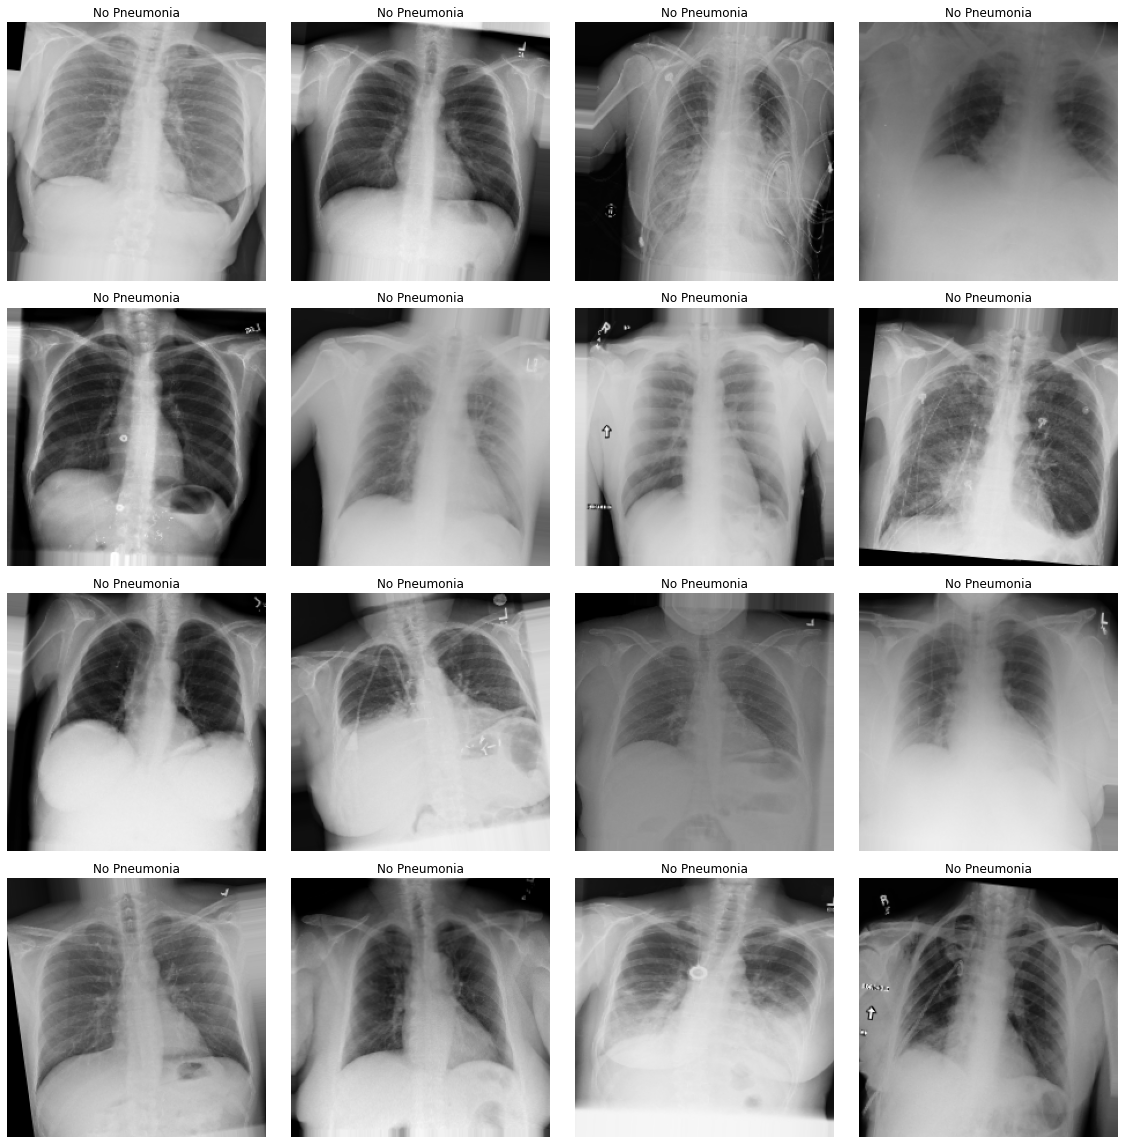

In [8]:
## Look at some examples of augmented training data. 

# Make sure to have created train_gen first:
train_gen = make_train_gen(train_data)

# Get batch of augmented images and labels
t_x, t_y = next(train_gen)

# Plot a 4x4 grid of augmented images
fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    # If images are RGB, use c_x for imshow; if grayscale, use c_x[:,:,0]. 
    if c_x.shape[-1] == 1:
        c_ax.imshow(c_x[:, :, 0], cmap='bone')
    else:
        c_ax.imshow(c_x)
    c_ax.set_title('Pneumonia' if int(float(c_y)) == 1 else 'No Pneumonia')
    c_ax.axis('off')
plt.tight_layout()
plt.show()

Found 1145 validated image filenames.


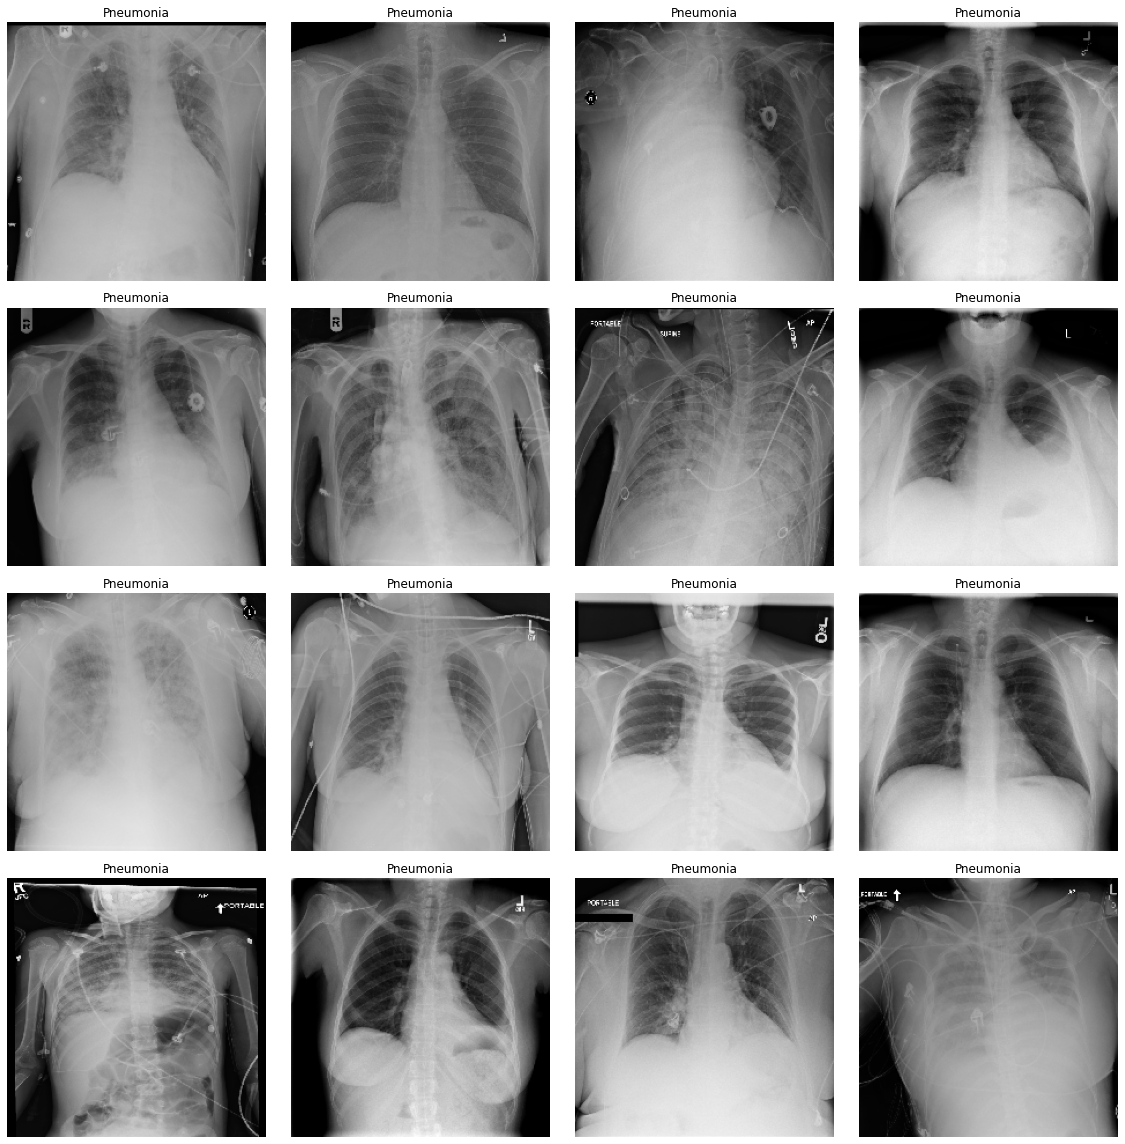

In [9]:
#Since pneumonia is small percent of cases, will visualize examples here. 
pneumonia_only = train_data[train_data['pneumonia_class'] == '1']
pneumonia_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=pneumonia_only,
    x_col='path',
    y_col='pneumonia_class',
    class_mode='raw',  # Use 'raw' for single-class visualization
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)
t_x, t_y = next(pneumonia_gen)

# Get a batch from the pneumonia-only generator
t_x, t_y = next(pneumonia_gen)

fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    if c_x.shape[-1] == 1:
        c_ax.imshow(c_x[:, :, 0], cmap='bone')
    else:
        c_ax.imshow(c_x)
    c_ax.set_title('Pneumonia')
    c_ax.axis('off')
plt.tight_layout()
plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
#Import base VGG16 mod
from tensorflow.keras.applications import VGG16

def load_pretrained_model(input_shape=(224, 224, 3)):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    return base_model


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_my_model_with_cam(input_shape=(224, 224, 3)):
    base_model = load_pretrained_model(input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name='classification')(x)

    # For CAM, pick the last convolutional layer (e.g., 'block5_conv3' in VGG16)
    cam_layer = base_model.get_layer('block5_conv3').output

    # Model with two outputs: classification and CAM layer
    model = Model(inputs=base_model.input, outputs=[output, cam_layer])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss={'classification': 'binary_crossentropy'},
        metrics={'classification': ['accuracy', tf.keras.metrics.AUC(name='auc')]}
    )
    return model

# Usage:
my_model = build_my_model_with_cam()
my_model.summary()


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set the path to save the best model weights
weight_path = "xray_class_my_model.best.hdf5"

# Create a ModelCheckpoint callback to save the best model based on validation AUC
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_auc',          # Monitor validation AUC
    verbose=1,
    save_best_only=True,
    mode='max',                 # We want to maximize AUC
    save_weights_only=True
)

# Create an EarlyStopping callback to stop training if no improvement in validation AUC
early = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,                # Stop after 10 epochs with no improvement
    verbose=1
)

# Combine callbacks into a list
callbacks_list = [checkpoint, early]
print(callbacks_list)

[<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7e12a9327890>, <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7e12a9327710>]


### Start training! 

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

def build_my_model(input_shape=(224, 224, 3)):
    base_model = load_pretrained_model(input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name='classification')(x)

    # Model with only the classification output
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

my_model = build_my_model(input_shape=(224, 224, 3))
my_model.summary()

# For CAM visualization after training:
cam_model = Model(inputs=my_model.input, outputs=[
    my_model.output,
    my_model.get_layer('block5_conv3').output
])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [19]:
# Assuming train_gen, val_gen, and callbacks_list are already defined

#from workspace_utils import active_session

# Create generators (this is fast and does not need to be inside active_session)
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

history = my_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks_list
)

Found 89696 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2803 steps, validate for 701 steps
Epoch 1/10
   8/2803 [..............................] - ETA: 24:22:29 - loss: 0.3549 - accuracy: 0.8527 - auc: 0.2489e+WARNING:tensorflow:Can save best model only with val_auc available, skipping.


InvalidHeader: Invalid return character or leading space in header: Authorization

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

# Load the best model weights
my_model.load_weights(weight_path)

# Get a batch of validation data (X, y)
valX, valY = next(val_gen)  # Or use a larger batch or all validation data as needed

# Make predictions (probabilities)
pred_Y = my_model.predict(valX, batch_size=32, verbose=True)

# If you want binary predictions, you can threshold them (e.g., at 0.5)
binary_pred_Y = (pred_Y > 0.5).astype(int)

In [ ]:
def plot_auc(t_y, p_y):
    """
    Plots the ROC curve and prints the AUC score.
    t_y: ground truth labels (binary)
    p_y: predicted probabilities
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimizes your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

from sklearn.metrics import f1_score, precision_score, recall_score

def find_best_threshold(y_true, y_pred_probs):
    """
    Finds the threshold that maximizes F1 score.
    Returns the best threshold and prints F1, precision, recall at that threshold.
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        y_pred = (y_pred_probs > thresh).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    # Calculate precision and recall at best threshold
    y_pred_best = (y_pred_probs > best_threshold).astype(int)
    precision = precision_score(y_true, y_pred_best)
    recall = recall_score(y_true, y_pred_best)
    print(f"Best threshold: {best_threshold:.2f}")
    print(f"F1 score: {best_f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return best_threshold

# Example usage after prediction:
# best_thresh = find_best_threshold(valY, pred_Y)
# binary_pred_Y = (pred_Y > best_thresh).astype(int)

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

## Let's look at some examples of true vs. predicted with our best model: 

def plot_true_vs_pred(valX, valY, pred_Y, threshold, n=100):
    """
    Plots n examples of true vs. predicted labels.
    valX: validation images (numpy array)
    valY: true labels (numpy array)
    pred_Y: predicted probabilities (numpy array)
    threshold: threshold for binary classification
    n: number of examples to plot (default 100)
    """
    import matplotlib.pyplot as plt

    binary_pred_Y = (pred_Y > threshold).astype(int)
    fig, m_axs = plt.subplots(10, 10, figsize=(16, 16))
    i = 0
    for (c_x, c_y, p_y, c_ax) in zip(valX[0:n], valY[0:n], binary_pred_Y[0:n], m_axs.flatten()):
        c_ax.imshow(c_x[:, :, 0], cmap='bone')
        c_ax.set_title(f'True: {int(c_y)}, Pred: {int(p_y)}')
        c_ax.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

# Example usage after finding best threshold:
# plot_true_vs_pred(valX, valY, pred_Y, best_thresh, n=100)

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved to my_model_architecture.json")